# **Esercitazione 5**

In [ ]:
! pip install timm

## **Imagenette Dataset**


In [2]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torchvision
import torchvision.transforms as T

In [3]:
_ = torchvision.datasets.Imagenette(
    root='./data',
    # split="train",
    download=True,
)

LABELS_MAP = {
    "n01440764": "fish",
    "n02102040": "dog",
    "n02979186": "speaker",
    "n03000684": "electric saw",
    "n03028079": "church",
    "n03394916": "trumpet",
    "n03417042": "truck",
    "n03425413": "gas pump",
    "n03445777": "golf ball",
    "n03888257": "parachute"
}

class ImageFolderDataset(Dataset):

  def __init__(
      self,
      root_dir: str, # "./data/imagenette2"
      split: str = "train",
      labels_map: dict = LABELS_MAP,
      transform: callable = None
  ) -> None:

    self.split_dir = os.path.join(root_dir, split) # e.g. "./data/imagenette2/train"

    # mi serve perchè ad ogni label deve essere associato un numero
    # e.g. { "n01440764": 0, "n02102040": 1}
    label2target = {
        label: idx for idx, label in enumerate(labels_map.keys())
    }

    self.images = []
    self.targets = []
    self.labels = []
    for class_id in os.listdir(self.split_dir):
      class_dir_path = os.path.join(self.split_dir, class_id)
      images = os.listdir(class_dir_path)
      self.images += [
          os.path.join(class_dir_path, image) for image in images
      ]
      self.targets += [label2target[class_id]]*len(images)

      self.labels += [labels_map[class_id]]*len(images)

    self.transform = transform


  def __getitem__(self, index):

    image_path = self.images[index]
    image_target = self.targets[index]
    image_label = self.labels[index]

    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    return image, image_target

  def __len__(self):
    return len(self.images)


100%|██████████| 1557161267/1557161267 [01:49<00:00, 14259826.96it/s]


Extracting ./data/imagenette2.tgz to ./data


random horizontal flip
color jitter
random rotation
random resized crop
random grayscale
random vertical flip
normalization

In [4]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(0.5),
    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=.5),
    T.RandomGrayscale(p=0.3),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolderDataset(
    root_dir='./data/imagenette2',
    split="train",
    transform=train_transform,
)

val_dataset = ImageFolderDataset(
    root_dir='./data/imagenette2',
    split="val",
    transform=val_transform,
)

batch_size=32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## **Pre-trained ResNet18**

In [5]:
from timm import create_model
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

In [6]:
model = create_model("resnet18", pretrained=True, num_classes=10) # no pre-trained weights

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [7]:
# model test
x = torch.rand((1, 3, 224, 224))
logits = model(x)
print(logits.shape)

torch.Size([1, 10])


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
device = "cuda" # "cuda"
model.to(device);

In [ ]:
# Train the neural network
num_epochs = 30
log_every_n_iter = int(0.1*(len(train_loader)))
for epoch in range(num_epochs):
  # train loop
  model.train()
  epoch_loss = 0.0
  print(f"Epoch: {epoch}")
  for i, batch in enumerate(train_loader, 0):
    # batch --> (images, targets)
    x, targets = [el.to(device) for el in batch]
    # set optimizer a zero
    optimizer.zero_grad()
    # forward pass
    logits = model(x)
    # calcolo della loss
    loss = criterion(logits, targets)
    # backward pass
    loss.backward()
    # optimizer step --> update weights
    optimizer.step()
    epoch_loss += loss.item()
    if (i+1) % log_every_n_iter == 0:    # Print every log_every_n_iter mini-batches
        print(f"> iter [{i+1}/{len(train_loader)}] - train_loss={epoch_loss/log_every_n_iter:.4f}")
        epoch_loss = 0.0
    # test loop
  model.eval()
  test_loss = []
  total, correct = 0, 0
  with torch.no_grad():
    for batch in test_loader:
      x, targets = [el.to(device) for el in batch]
      logits = model(x)
      loss = criterion(logits, targets)
      test_loss.append(loss.item())
      # ottengo gli indici dove trovo la max probabilità
      _, preds = torch.max(logits.data, 1)
      total += targets.size(0)
      correct += (preds == targets).sum().item()

  print("Test report:")
  print(f"\t test_loss={sum(test_loss)/len(test_loss):.4f} - test_accuracy={correct/total:.4f}")

  print(" \n *************** \n")

print('Finished Training')

Epoch: 0
> iter [29/296] - train_loss=2.2649
> iter [58/296] - train_loss=2.2497
> iter [87/296] - train_loss=2.2281
> iter [116/296] - train_loss=2.2082
> iter [145/296] - train_loss=2.1900
> iter [174/296] - train_loss=2.1706
> iter [203/296] - train_loss=2.1436
> iter [232/296] - train_loss=2.1296
> iter [261/296] - train_loss=2.1129
> iter [290/296] - train_loss=2.0838
Test report:
	 test_loss=2.0359 - test_accuracy=0.6278
 
 *************** 

Epoch: 1
> iter [29/296] - train_loss=2.0603
> iter [58/296] - train_loss=2.0424
> iter [87/296] - train_loss=2.0123
> iter [116/296] - train_loss=1.9924
> iter [145/296] - train_loss=1.9746
> iter [174/296] - train_loss=1.9536
> iter [203/296] - train_loss=1.9326
> iter [232/296] - train_loss=1.9097
> iter [261/296] - train_loss=1.8799
> iter [290/296] - train_loss=1.8594
Test report:
	 test_loss=1.7959 - test_accuracy=0.8252
 
 *************** 

Epoch: 2
> iter [29/296] - train_loss=1.8495
> iter [58/296] - train_loss=1.8045
> iter [87/296]

In [ ]:
torch.save(model.state_dict(), "model.pt")

In [26]:
model = create_model("resnet18", pretrained=False, num_classes=10)

In [27]:
state_dict = torch.load("model_loss=0.2221_acc=0.9623.pt", map_location="cpu")
model.load_state_dict(state_dict)
model.to(device);
model.eval();

### Inference

In [28]:
import random
import numpy as np

In [44]:
idx = random.randint(0, len(val_dataset))
img, target = val_dataset[idx]
gt_label = val_dataset.labels[idx]
image_path = val_dataset.images[idx]
print(img.shape)
# we need to augment the first dimension --> from (C, H, W) -> (B, C, H, W)
x = img.unsqueeze(0)
print(x.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [45]:
import torch.nn.functional as F

with torch.no_grad():
  model.eval()
  logits = model(x.to(device))
  probs = F.softmax(logits, 1)
  print(probs.data)
  pred_prob, pred_class = torch.max(probs.data, 1)
  print(pred_class, pred_prob)

tensor([[5.0659e-03, 9.7701e-01, 2.7671e-03, 3.1782e-03, 5.8911e-04, 1.4162e-03,
         9.6682e-04, 1.0050e-03, 6.1195e-03, 1.8852e-03]], device='cuda:0')
tensor([1], device='cuda:0') tensor([0.9770], device='cuda:0')


In [46]:
image = Image.open(image_path)

In [47]:
import matplotlib.pyplot as plt

Predicted class is dog with prob=0.9770 - Ground Truth class is dog


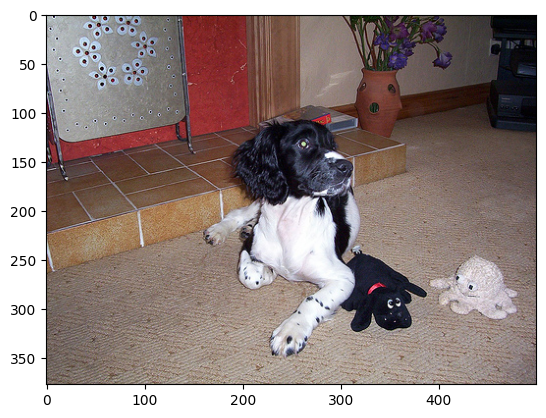

In [48]:
pred_label_key = list(LABELS_MAP)[pred_class[0]]
pred_label_name = LABELS_MAP[pred_label_key]

print(f"Predicted class is {pred_label_name} with prob={pred_prob[0]:.4f} - Ground Truth class is {gt_label}")
plt.imshow(image)